# Layout Detection with Surya
Detect document layout regions using Surya, a high-quality open-source document AI library.

**Features:**
- **Deskewing:** Automatically straightens skewed/rotated scans before detection
- **Surya:** State-of-the-art multilingual document layout detection
- **No authentication required:** Fully open-source and public

In [1]:
# Install dependencies (run once)
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])

# Install required packages
print("Installing dependencies...")

packages = [
    "surya-ocr",  # Surya for layout detection
    "torch",
    "torchvision",
    "pillow",
    "matplotlib",
    "opencv-python",
    "scipy"
]

for pkg in packages:
    try:
        pkg_import = pkg.replace("-", "_").split("[")[0]
        if pkg_import == "surya_ocr":
            pkg_import = "surya"
        __import__(pkg_import)
    except ImportError:
        print(f"Installing {pkg}...")
        install(pkg)

print("Dependencies ready!")

Installing dependencies...
Installing pillow...
Installing opencv-python...
Dependencies ready!


In [2]:
import os
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from IPython.display import display
import cv2
from scipy import ndimage
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.1+cpu
CUDA available: False


In [3]:
# Configuration
INPUT_FOLDER = Path("filled_documents")
OUTPUT_FOLDER = Path("layout_results")
OUTPUT_FOLDER.mkdir(parents=True, exist_ok=True)

# Library name for output files
LIBRARY_NAME = "surya"

# Confidence threshold (0-1)
CONFIDENCE_THRESHOLD = 0.5

# Deskew settings
ENABLE_DESKEW = True
DESKEW_ANGLE_THRESHOLD = 0.5  # Only deskew if angle > this value (degrees)

# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cpu


## Deskewing Functions
These functions detect and correct skew in document images before layout detection.

In [4]:
def detect_skew_angle(image: np.ndarray) -> float:
    """
    Detect the skew angle of a document image using Hough Line Transform.
    
    Args:
        image: Input image as numpy array (RGB or grayscale)
    
    Returns:
        Skew angle in degrees (positive = clockwise rotation needed)
    """
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()
    
    # Apply edge detection
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    
    # Dilate edges to connect broken lines
    kernel = np.ones((3, 3), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)
    
    # Detect lines using Hough Transform
    lines = cv2.HoughLinesP(
        edges,
        rho=1,
        theta=np.pi / 180,
        threshold=100,
        minLineLength=100,
        maxLineGap=10
    )
    
    if lines is None or len(lines) == 0:
        return 0.0
    
    # Calculate angles of detected lines
    angles = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x2 - x1 == 0:
            continue
        angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
        
        # Only consider nearly horizontal lines (within 45 degrees of horizontal)
        if abs(angle) < 45:
            angles.append(angle)
    
    if len(angles) == 0:
        return 0.0
    
    # Use median angle to be robust to outliers
    median_angle = np.median(angles)
    
    return median_angle


def deskew_image(image: np.ndarray, angle: float = None, background_color: tuple = (255, 255, 255)) -> tuple:
    """
    Deskew (straighten) a document image.
    
    Args:
        image: Input image as numpy array (RGB)
        angle: Skew angle in degrees. If None, it will be auto-detected.
        background_color: Color to fill empty areas after rotation
    
    Returns:
        Tuple of (deskewed_image, detected_angle)
    """
    if angle is None:
        angle = detect_skew_angle(image)
    
    if abs(angle) < DESKEW_ANGLE_THRESHOLD:
        # Angle is negligible, no deskewing needed
        return image, angle
    
    # Get image dimensions
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    
    # Calculate rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Calculate new image bounds to avoid cropping
    cos = np.abs(rotation_matrix[0, 0])
    sin = np.abs(rotation_matrix[0, 1])
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))
    
    # Adjust rotation matrix for new bounds
    rotation_matrix[0, 2] += (new_w / 2) - center[0]
    rotation_matrix[1, 2] += (new_h / 2) - center[1]
    
    # Perform rotation
    deskewed = cv2.warpAffine(
        image,
        rotation_matrix,
        (new_w, new_h),
        flags=cv2.INTER_CUBIC,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=background_color
    )
    
    return deskewed, angle


def preprocess_for_layout(pil_image: Image.Image, enable_deskew: bool = True) -> tuple:
    """
    Preprocess a PIL image for layout detection.
    
    Args:
        pil_image: Input PIL Image
        enable_deskew: Whether to apply deskewing
    
    Returns:
        Tuple of (preprocessed_pil_image, skew_angle)
    """
    image_array = np.array(pil_image)
    
    if enable_deskew:
        deskewed_array, angle = deskew_image(image_array)
        return Image.fromarray(deskewed_array), angle
    else:
        return pil_image, 0.0


print("Deskewing functions loaded!")

Deskewing functions loaded!


In [5]:
# Load Surya layout detection model
from surya.detection import DetectionPredictor

print("Loading Surya detection model...")

# Initialize the detection predictor
det_predictor = DetectionPredictor()

print("Surya model loaded!")
print("\nSurya detects text lines and blocks in documents.")

Loading Surya detection model...


Surya model loaded!

Surya detects text lines and blocks in documents.


In [6]:
def detect_layout_surya(image: Image.Image, threshold: float = 0.5) -> list:
    """
    Detect layout regions using Surya model.
    
    Args:
        image: PIL Image
        threshold: Confidence threshold
    
    Returns:
        List of detection dictionaries
    """
    # Run detection
    results = det_predictor([image])
    
    detections = []
    if results and len(results) > 0:
        result = results[0]
        
        # Get text lines from bboxes
        for i, bbox in enumerate(result.bboxes):
            # bbox is a list of 4 coordinates [x1, y1, x2, y2]
            if hasattr(bbox, 'bbox'):
                x1, y1, x2, y2 = bbox.bbox
                conf = bbox.confidence if hasattr(bbox, 'confidence') else 1.0
            else:
                # bbox might be a list directly
                x1, y1, x2, y2 = bbox[:4] if len(bbox) >= 4 else (0, 0, 0, 0)
                conf = bbox[4] if len(bbox) > 4 else 1.0
            
            if conf >= threshold:
                detections.append({
                    "type": "text_line",
                    "confidence": float(conf),
                    "bbox": {"x1": int(x1), "y1": int(y1), "x2": int(x2), "y2": int(y2)}
                })
    
    return detections

print("Detection function ready!")

Detection function ready!


In [7]:
# List available documents
image_extensions = {'.png', '.jpg', '.jpeg', '.tiff', '.bmp'}
documents = sorted([f for f in INPUT_FOLDER.iterdir() 
                    if f.suffix.lower() in image_extensions])

if not documents:
    print(f"No images found in '{INPUT_FOLDER}' folder.")
    print("Run the form_filler and scan_simulator notebooks first.")
else:
    print(f"Found {len(documents)} documents:")
    for i, doc in enumerate(documents):
        print(f"  {i}: {doc.name}")

Found 24 documents:
  0: Demand Letter_batch_1.png
  1: Demand Letter_batch_1_1.png
  2: Demand Letter_batch_1_2.png
  3: Demand Letter_batch_1_3.png
  4: Demand Letter_batch_1_4.png
  5: Demand Letter_batch_1_5.png
  6: Demand Letter_batch_2.png
  7: Demand Letter_batch_2_1.png
  8: Demand Letter_batch_2_2.png
  9: Demand Letter_batch_2_3.png
  10: Demand Letter_batch_2_4.png
  11: Demand Letter_batch_2_5.png
  12: Demand Letter_filled_computer.png
  13: Demand Letter_filled_computer_1.png
  14: Demand Letter_filled_computer_2.png
  15: Demand Letter_filled_computer_3.png
  16: Demand Letter_filled_computer_4.png
  17: Demand Letter_filled_computer_5.png
  18: Demand Letter_filled_handwriting.png
  19: Demand Letter_filled_handwriting_1.png
  20: Demand Letter_filled_handwriting_2.png
  21: Demand Letter_filled_handwriting_3.png
  22: Demand Letter_filled_handwriting_4.png
  23: Demand Letter_filled_handwriting_5.png


Selected: Demand Letter_batch_1.png
Original image size: (1224, 1584)

Deskewing enabled: True
Detected skew angle: 0.00 degrees
Processed image size: (1224, 1584)


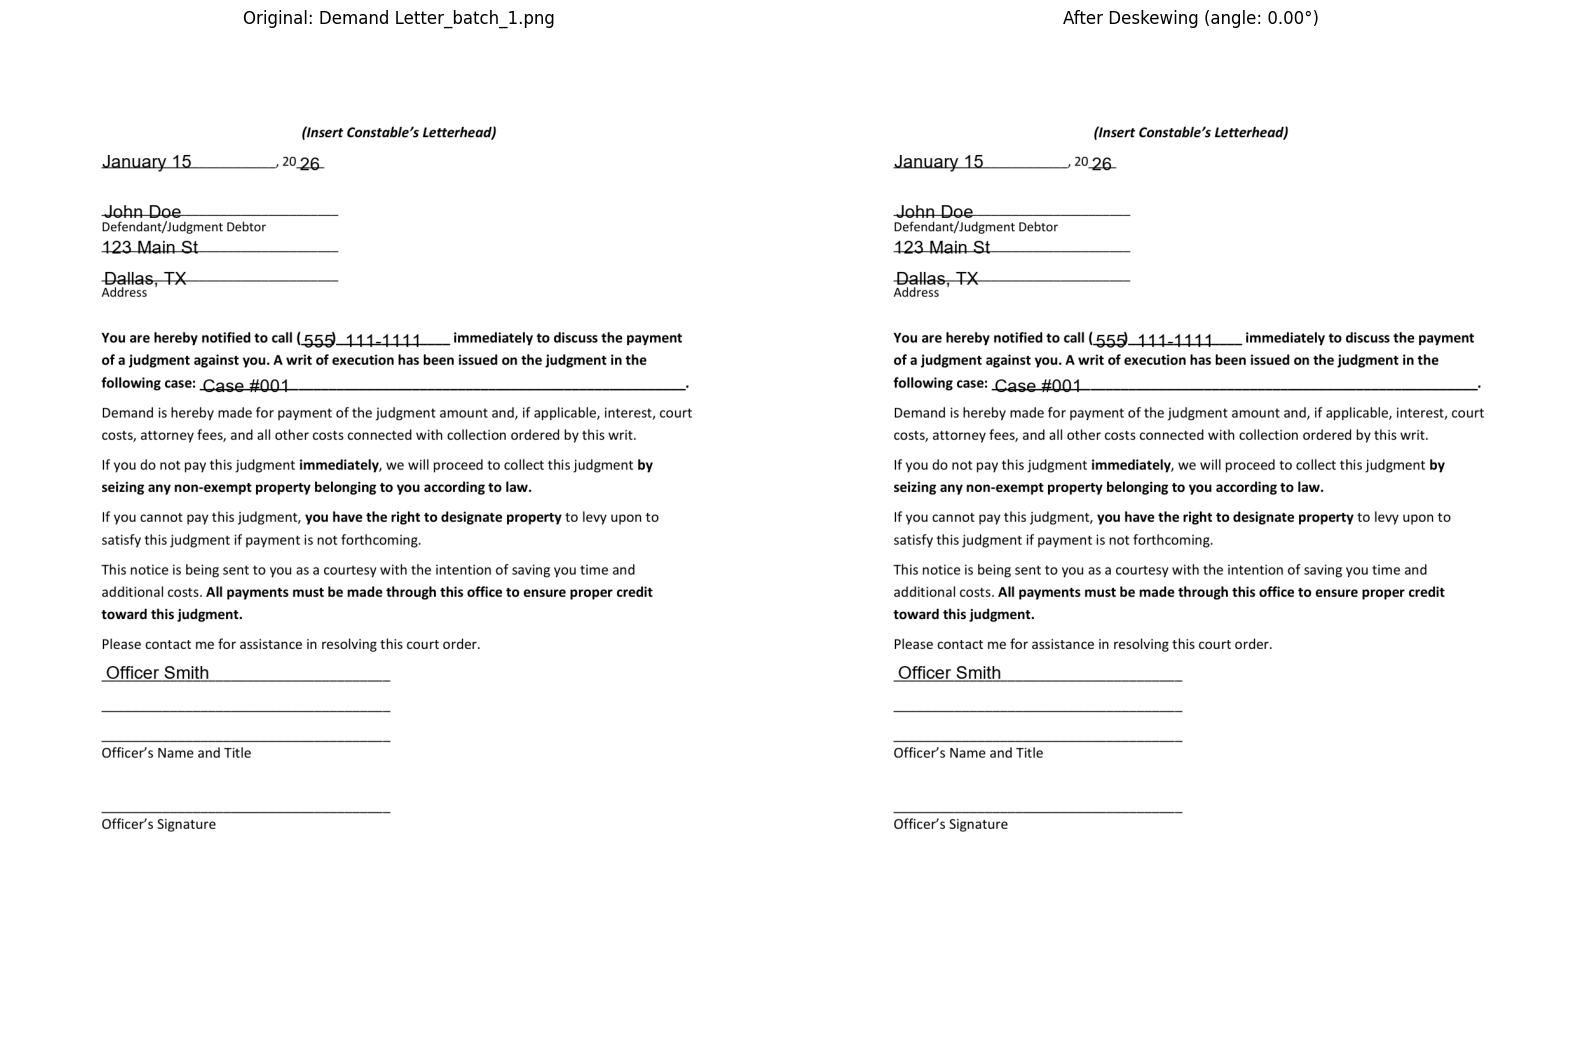

In [8]:
# ============================================================
# CONFIGURATION: Select document to analyze
# ============================================================
SELECTED_DOC_INDEX = 0  # Change this to select a different document

if documents:
    selected_doc = documents[SELECTED_DOC_INDEX]
    print(f"Selected: {selected_doc.name}")
    
    # Load image
    original_image = Image.open(selected_doc).convert("RGB")
    print(f"Original image size: {original_image.size}")
    
    # Apply deskewing
    print(f"\nDeskewing enabled: {ENABLE_DESKEW}")
    image, skew_angle = preprocess_for_layout(original_image, enable_deskew=ENABLE_DESKEW)
    print(f"Detected skew angle: {skew_angle:.2f} degrees")
    print(f"Processed image size: {image.size}")
    
    # Display comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 12))
    
    axes[0].imshow(np.array(original_image))
    axes[0].set_title(f"Original: {selected_doc.name}")
    axes[0].axis('off')
    
    axes[1].imshow(np.array(image))
    axes[1].set_title(f"After Deskewing (angle: {skew_angle:.2f}°)")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No documents available")

In [9]:
# Run layout detection on deskewed image
if 'image' in dir():
    print("Running layout detection with Surya...")
    
    # Run inference
    detections = detect_layout_surya(image, threshold=CONFIDENCE_THRESHOLD)
    
    print(f"\nDetected {len(detections)} regions:")
    print("-" * 60)
    
    layout_results = []
    for i, det in enumerate(detections):
        det["id"] = i + 1
        layout_results.append(det)
        
        bbox = det["bbox"]
        print(f"{i+1}. Type: {det['type']:15} | Score: {det['confidence']:.2f} | "
              f"Box: ({bbox['x1']}, {bbox['y1']}) - ({bbox['x2']}, {bbox['y2']})")
else:
    print("Load a document first (run the cell above)")

Running layout detection with Surya...


Detecting bboxes: 100%|██████████| 1/1 [00:03<00:00,  3.17s/it]


Detected 23 regions:
------------------------------------------------------------
1. Type: text_line       | Score: 0.97 | Box: (454, 149) - (768, 169)
2. Type: text_line       | Score: 0.98 | Box: (140, 191) - (497, 219)
3. Type: text_line       | Score: 0.85 | Box: (141, 273) - (490, 293)
4. Type: text_line       | Score: 0.92 | Box: (141, 294) - (436, 318)
5. Type: text_line       | Score: 0.91 | Box: (140, 327) - (519, 351)
6. Type: text_line       | Score: 0.83 | Box: (140, 372) - (513, 402)
7. Type: text_line       | Score: 0.81 | Box: (142, 401) - (221, 418)
8. Type: text_line       | Score: 0.94 | Box: (140, 471) - (1061, 496)
9. Type: text_line       | Score: 0.99 | Box: (140, 505) - (1005, 529)
10. Type: text_line       | Score: 0.94 | Box: (140, 544) - (1038, 566)
11. Type: text_line       | Score: 0.99 | Box: (140, 590) - (1078, 612)
12. Type: text_line       | Score: 0.99 | Box: (140, 622) - (988, 646)
13. Type: text_line       | Score: 0.99 | Box: (140, 672) - (1015, 694

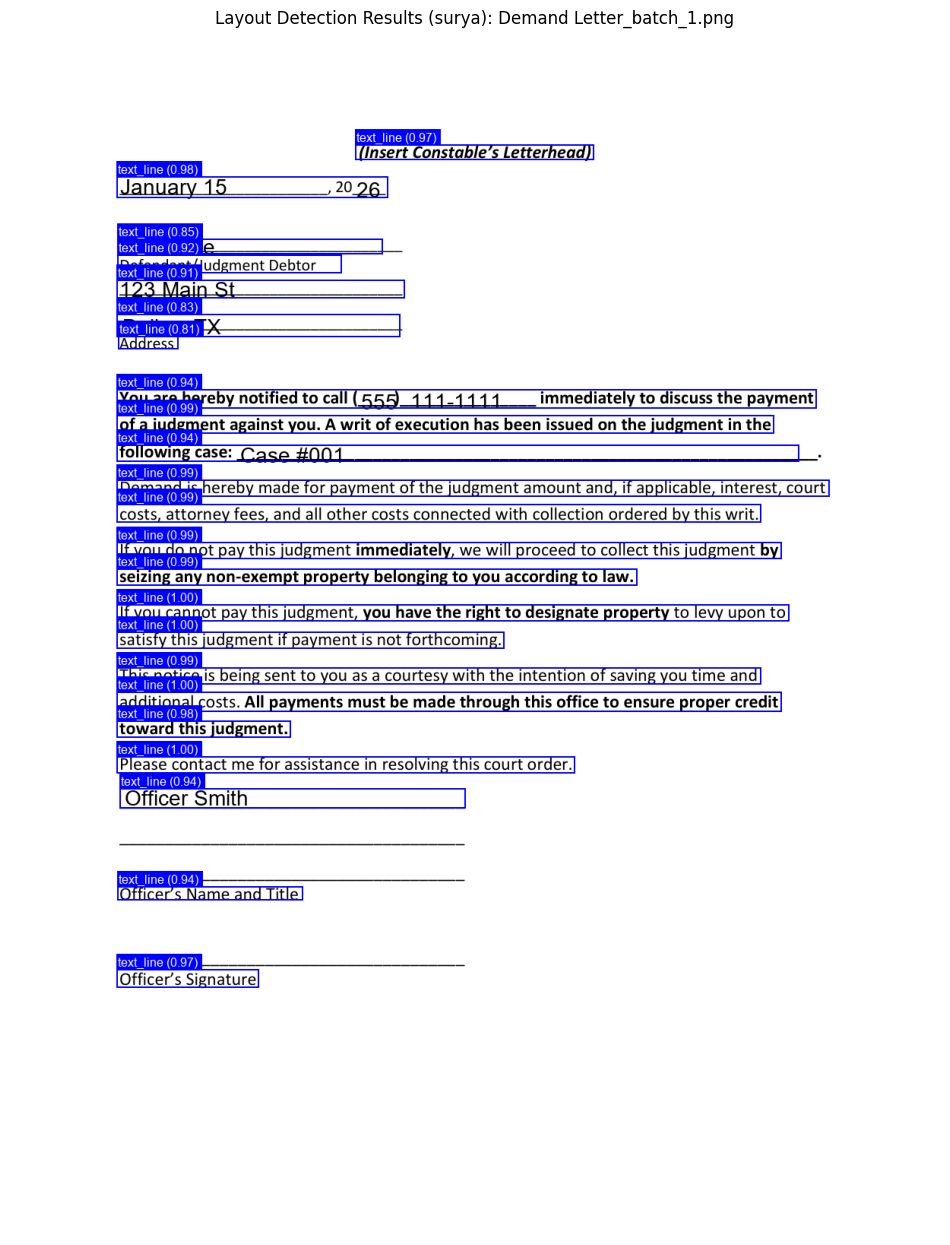

Saved visualization: layout_results\Demand Letter_batch_1_layout_surya.png


In [10]:
# Visualize detection results
def draw_detections(image: Image.Image, detections: list) -> np.ndarray:
    """
    Draw bounding boxes on image.
    """
    img_draw = image.copy()
    draw = ImageDraw.Draw(img_draw)
    
    # Colors for different types
    colors = {
        "text_line": "blue",
        "Text": "blue",
        "Title": "red",
        "List": "green",
        "Table": "purple",
        "Figure": "orange"
    }
    
    try:
        font = ImageFont.truetype("arial.ttf", 16)
    except:
        font = ImageFont.load_default()
    
    for det in detections:
        bbox = det["bbox"]
        x1, y1, x2, y2 = bbox["x1"], bbox["y1"], bbox["x2"], bbox["y2"]
        color = colors.get(det["type"], "blue")
        
        # Draw rectangle
        draw.rectangle([x1, y1, x2, y2], outline=color, width=2)
        
        # Draw label
        label = f"{det['type']} ({det['confidence']:.2f})"
        draw.rectangle([x1, y1 - 20, x1 + len(label) * 7, y1], fill=color)
        draw.text((x1 + 2, y1 - 18), label, fill="white", font=font)
    
    return np.array(img_draw)


if 'layout_results' in dir():
    # Draw detections
    viz_image = draw_detections(image, layout_results)
    
    # Display
    plt.figure(figsize=(12, 16))
    plt.imshow(viz_image)
    plt.title(f"Layout Detection Results ({LIBRARY_NAME}): {selected_doc.name}")
    plt.axis('off')
    plt.show()
    
    # Save visualization with library postfix
    viz_path = OUTPUT_FOLDER / f"{selected_doc.stem}_layout_{LIBRARY_NAME}.png"
    Image.fromarray(viz_image).save(viz_path)
    print(f"Saved visualization: {viz_path}")
else:
    print("Run detection first (run the cell above)")

In [11]:
# Filter and extract specific region types
if 'layout_results' in dir():
    # Group by type
    regions_by_type = {}
    for region in layout_results:
        rtype = region["type"]
        if rtype not in regions_by_type:
            regions_by_type[rtype] = []
        regions_by_type[rtype].append(region)
    
    print("Regions by type:")
    print("-" * 40)
    for region_type, regions in regions_by_type.items():
        print(f"  {region_type}: {len(regions)} region(s)")

Regions by type:
----------------------------------------
  text_line: 23 region(s)


In [12]:
# Crop and save individual regions
if 'layout_results' in dir() and len(layout_results) > 0:
    regions_folder = OUTPUT_FOLDER / f"{selected_doc.stem}_regions_{LIBRARY_NAME}"
    regions_folder.mkdir(exist_ok=True)
    
    print(f"Extracting regions to: {regions_folder}")
    
    for region in layout_results:
        bbox = region["bbox"]
        x1, y1, x2, y2 = bbox["x1"], bbox["y1"], bbox["x2"], bbox["y2"]
        
        # Crop region from deskewed image
        cropped = image.crop((x1, y1, x2, y2))
        
        # Save
        region_path = regions_folder / f"region_{region['id']}_{region['type']}.png"
        cropped.save(region_path)
        print(f"  Saved: {region_path.name}")
    
    print(f"\nExtracted {len(layout_results)} regions")

Extracting regions to: layout_results\Demand Letter_batch_1_regions_surya
  Saved: region_1_text_line.png
  Saved: region_2_text_line.png
  Saved: region_3_text_line.png
  Saved: region_4_text_line.png
  Saved: region_5_text_line.png
  Saved: region_6_text_line.png
  Saved: region_7_text_line.png
  Saved: region_8_text_line.png
  Saved: region_9_text_line.png
  Saved: region_10_text_line.png
  Saved: region_11_text_line.png
  Saved: region_12_text_line.png
  Saved: region_13_text_line.png
  Saved: region_14_text_line.png
  Saved: region_15_text_line.png
  Saved: region_16_text_line.png
  Saved: region_17_text_line.png
  Saved: region_18_text_line.png
  Saved: region_19_text_line.png
  Saved: region_20_text_line.png
  Saved: region_21_text_line.png
  Saved: region_22_text_line.png
  Saved: region_23_text_line.png

Extracted 23 regions


In [13]:
# Export results to JSON
if 'layout_results' in dir():
    export_data = {
        "document": selected_doc.name,
        "library": LIBRARY_NAME,
        "image_width": image.size[0],
        "image_height": image.size[1],
        "deskew_enabled": ENABLE_DESKEW,
        "skew_angle": skew_angle,
        "confidence_threshold": CONFIDENCE_THRESHOLD,
        "num_regions": len(layout_results),
        "regions": layout_results
    }
    
    # Save JSON with library postfix
    json_path = OUTPUT_FOLDER / f"{selected_doc.stem}_layout_{LIBRARY_NAME}.json"
    with open(json_path, 'w') as f:
        json.dump(export_data, f, indent=2)
    
    print(f"Saved results to: {json_path}")
    print("\nJSON preview:")
    print(json.dumps(export_data, indent=2)[:800] + "...")

Saved results to: layout_results\Demand Letter_batch_1_layout_surya.json

JSON preview:
{
  "document": "Demand Letter_batch_1.png",
  "library": "surya",
  "image_width": 1224,
  "image_height": 1584,
  "deskew_enabled": true,
  "skew_angle": 0.0,
  "confidence_threshold": 0.5,
  "num_regions": 23,
  "regions": [
    {
      "type": "text_line",
      "confidence": 0.9666078686714172,
      "bbox": {
        "x1": 454,
        "y1": 149,
        "x2": 768,
        "y2": 169
      },
      "id": 1
    },
    {
      "type": "text_line",
      "confidence": 0.9752894043922424,
      "bbox": {
        "x1": 140,
        "y1": 191,
        "x2": 497,
        "y2": 219
      },
      "id": 2
    },
    {
      "type": "text_line",
      "confidence": 0.848528265953064,
      "bbox": {
        "x1": 141,
        "y1": 273,
        "x2": 490,
        "y2": 293
      },
      "id": ...


In [14]:
# Batch process all documents
if documents:
    print(f"Processing {len(documents)} documents with {LIBRARY_NAME}...")
    print(f"Deskewing enabled: {ENABLE_DESKEW}\n")
    
    all_results = []
    
    for doc in documents:
        print(f"Processing: {doc.name}")
        
        # Load image
        orig_img = Image.open(doc).convert("RGB")
        
        # Deskew
        img, angle = preprocess_for_layout(orig_img, enable_deskew=ENABLE_DESKEW)
        print(f"  Skew angle: {angle:.2f}°")
        
        # Detect layout
        doc_detections = detect_layout_surya(img, threshold=CONFIDENCE_THRESHOLD)
        
        # Save visualization with library postfix
        if len(doc_detections) > 0:
            viz = draw_detections(img, doc_detections)
            viz_path = OUTPUT_FOLDER / f"{doc.stem}_layout_{LIBRARY_NAME}.png"
            Image.fromarray(viz).save(viz_path)
        
        # Store results
        doc_data = {
            "document": doc.name,
            "library": LIBRARY_NAME,
            "skew_angle": angle,
            "num_regions": len(doc_detections),
            "regions": []
        }
        
        for det in doc_detections:
            doc_data["regions"].append({
                "type": det["type"],
                "score": round(det["confidence"], 4)
            })
        
        all_results.append(doc_data)
        print(f"  Found {len(doc_detections)} regions")
    
    # Save batch results with library postfix
    batch_json_path = OUTPUT_FOLDER / f"batch_results_{LIBRARY_NAME}.json"
    with open(batch_json_path, 'w') as f:
        json.dump(all_results, f, indent=2)
    
    print(f"\nDone! Results saved to {OUTPUT_FOLDER}")
else:
    print("No documents to process")

Processing 24 documents with surya...
Deskewing enabled: True

Processing: Demand Letter_batch_1.png
  Skew angle: 0.00°


Detecting bboxes: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


  Found 23 regions
Processing: Demand Letter_batch_1_1.png
  Skew angle: 3.01°


Detecting bboxes: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it]


  Found 23 regions
Processing: Demand Letter_batch_1_2.png
  Skew angle: 2.11°


Detecting bboxes: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


  Found 22 regions
Processing: Demand Letter_batch_1_3.png
  Skew angle: -2.98°


Detecting bboxes: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


  Found 23 regions
Processing: Demand Letter_batch_1_4.png
  Skew angle: 1.06°


Detecting bboxes: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


  Found 23 regions
Processing: Demand Letter_batch_1_5.png
  Skew angle: -0.90°


Detecting bboxes: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


  Found 23 regions
Processing: Demand Letter_batch_2.png
  Skew angle: 0.00°


Detecting bboxes: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


  Found 23 regions
Processing: Demand Letter_batch_2_1.png
  Skew angle: -2.02°


Detecting bboxes: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it]


  Found 23 regions
Processing: Demand Letter_batch_2_2.png
  Skew angle: 2.94°


Detecting bboxes: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


  Found 23 regions
Processing: Demand Letter_batch_2_3.png
  Skew angle: 0.96°


Detecting bboxes: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it]


  Found 24 regions
Processing: Demand Letter_batch_2_4.png
  Skew angle: 0.00°


Detecting bboxes: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


  Found 24 regions
Processing: Demand Letter_batch_2_5.png
  Skew angle: 1.99°


Detecting bboxes: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


  Found 23 regions
Processing: Demand Letter_filled_computer.png
  Skew angle: 0.00°


Detecting bboxes: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


  Found 24 regions
Processing: Demand Letter_filled_computer_1.png
  Skew angle: -0.69°


Detecting bboxes: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


  Found 24 regions
Processing: Demand Letter_filled_computer_2.png
  Skew angle: 0.00°


Detecting bboxes: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


  Found 24 regions
Processing: Demand Letter_filled_computer_3.png
  Skew angle: 0.99°


Detecting bboxes: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


  Found 24 regions
Processing: Demand Letter_filled_computer_4.png
  Skew angle: 0.90°


Detecting bboxes: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


  Found 24 regions
Processing: Demand Letter_filled_computer_5.png
  Skew angle: -1.81°


Detecting bboxes: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


  Found 24 regions
Processing: Demand Letter_filled_handwriting.png
  Skew angle: 0.00°


Detecting bboxes: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


  Found 24 regions
Processing: Demand Letter_filled_handwriting_1.png
  Skew angle: -0.99°


Detecting bboxes: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


  Found 24 regions
Processing: Demand Letter_filled_handwriting_2.png
  Skew angle: -1.01°


Detecting bboxes: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


  Found 24 regions
Processing: Demand Letter_filled_handwriting_3.png
  Skew angle: 1.02°


Detecting bboxes: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


  Found 23 regions
Processing: Demand Letter_filled_handwriting_4.png
  Skew angle: -1.01°


Detecting bboxes: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


  Found 24 regions
Processing: Demand Letter_filled_handwriting_5.png
  Skew angle: -2.99°


Detecting bboxes: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


  Found 24 regions

Done! Results saved to layout_results
